In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import torch
import random
from dash import Dash, dcc, html, Input, Output, State
import dash_bootstrap_components as dbc
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
from geopy.geocoders import Nominatim
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
### WARNING : in env\Lib\site-packages\torch_geometric_temporal\nn\attention\tsagcn.py :
### change 'from torch_geometric.utils.to_dense_adj' by 'from torch_geometric.utils'
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import DCRNN, GConvGRU
from sklearn.model_selection import TimeSeriesSplit

from gnn_model import StationFlowGCN
from train_gnn import(
    train_gnn_model,
    eval_gnn_model,
)
from utils.station_network import StationNetworkSimul
from utils.data import get_degraded_network_loader, create_degraded_networks
from utils.metrics import MAPE_loss


In [3]:
def create_numbat_dataframe(data_dir, year, weekdays, sheet_name):
    df_numbat = pd.DataFrame()
    for weekday in weekdays.keys():
        df_day = pd.read_excel(os.path.join(data_dir, f'NUMBAT {year}', f'NBT{str(year)[-2:]}{weekday}_outputs.xlsx'), sheet_name=sheet_name,skiprows=2, header=0)
        df_day['weekday'] = weekday
        df_day['weekday_idx'] = df_day['weekday'].apply(lambda x : weekdays[x])
        df_day = df_day.sort_values(by='weekday_idx')
        df_day = df_day.reset_index(drop=True)
        df_day = df_day.reset_index()
        df_numbat = pd.concat((df_numbat, df_day))
    
    rename_dict = {
        'Early     ' : 'Early',
        'AM Peak   ' : 'AM Peak',
        'Midday    ' : 'Midday',
        'PM Peak   ' : 'PM Peak',
        'Evening   ' : 'Evening',
        'Late      ' : 'Late'
    }
    df_numbat = df_numbat.rename(columns=rename_dict)
    return df_numbat

In [4]:
weekdays = {'MON':0,
 'TWT':1,
 'FRI':2,
 'SAT':3,
 'SUN':4}

data_dir = 'data/london/'

In [5]:
df_numbat_station_entries = create_numbat_dataframe(data_dir, 2023, weekdays,'Station_Entries')
df_numbat_station_exits = create_numbat_dataframe(data_dir, 2023, weekdays, 'Station_Exits')
df_numbat_link_loads = create_numbat_dataframe(data_dir, 2023, weekdays, 'Link_Loads')

In [6]:
df_numbat_link_loads

,index,Link,Line,Dir,Order,From NLC,From ASC,From Station,To NLC,To ASC,...,0300-0315,0315-0330,0330-0345,0345-0400,0400-0415,0415-0430,0430-0445,0445-0500,weekday,weekday_idx
0,0,ELEu_BAK_NB>LAMu_BAK_NB@BAK,Bakerloo,NB,1,570,ELEu,Elephant & Castle LU,628,LAMu,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MON,0
1,1,CHIr_WAG_UP>HIPr_WAG_UP@WAG,LO West Anglia,SB,15,6914,CHIr,Chingford,6919,HIPr,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MON,0
2,2,RECr_WAG_UP>HACr_WAGe_UP@WAG,LO West Anglia,SB,14,6967,RECr,Rectory Road,6867,HACr,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MON,0
3,3,SKWr_WAG_UP>RECr_WAG_UP@WAG,LO West Anglia,SB,13,6934,SKWr,Stoke Newington,6967,RECr,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MON,0
4,4,SMHr_WAG_UP>SKWr_WAG_UP@WAG,LO West Anglia,SB,12,6968,SMHr,Stamford Hill,6934,SKWr,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MON,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,1201,GMYr_EZL_EB>CTHr_EZL_EB@EZL,Elizabeth Line,EB,37,6878,GMYr,Goodmayes,6874,CTHr,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUN,4
1202,1202,SVKr_EZL_EB>GMYr_EZL_EB@EZL,Elizabeth Line,EB,36,6893,SVKr,Seven Kings,6878,GMYr,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUN,4
1203,1203,IFDr_EZL_EB>SVKr_EZL_EB@EZL,Elizabeth Line,EB,35,6881,IFDr,Ilford,6893,SVKr,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUN,4
1204,1204,FOGr_EZL_EB>MNPr_EZL_EB@EZL,Elizabeth Line,EB,33,6876,FOGr,Forest Gate,6883,MNPr,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SUN,4


In [7]:
num_links = df_numbat_link_loads['index'].nunique()
num_stations = df_numbat_station_exits['index'].nunique()

In [8]:
link_data = {
    i : df_numbat_link_loads.iloc[i][['From Station', 'To Station', 'Link', 'Line', 'Dir', 'Order']].to_dict()
    for i in range(num_links)
}

station_data = {
    i : df_numbat_station_exits.iloc[i][['Station', 'NLC']].to_dict()
    for i in range(num_stations)
}

In [9]:
station_data

{0: {'Station': 'Abbey Road', 'NLC': 750},
 1: {'Station': 'Queensway', 'NLC': 681},
 2: {'Station': 'Queensbury', 'NLC': 679},
 3: {'Station': 'Queens Road Peckham', 'NLC': 5424},
 4: {'Station': "Queen's Park", 'NLC': 680},
 5: {'Station': 'Putney Bridge', 'NLC': 678},
 6: {'Station': 'Pudding Mill Lane', 'NLC': 859},
 7: {'Station': 'Prince Regent', 'NLC': 888},
 8: {'Station': 'Preston Road', 'NLC': 677},
 9: {'Station': 'Poplar', 'NLC': 858},
 10: {'Station': 'Pontoon Dock', 'NLC': 538},
 11: {'Station': 'Plaistow', 'NLC': 676},
 12: {'Station': 'Pinner', 'NLC': 675},
 13: {'Station': 'Pimlico', 'NLC': 776},
 14: {'Station': 'Piccadilly Circus', 'NLC': 674},
 15: {'Station': 'Phipps Bridge', 'NLC': 9485},
 16: {'Station': 'Perivale', 'NLC': 673},
 17: {'Station': 'Penge West', 'NLC': 5378},
 18: {'Station': 'Peckham Rye', 'NLC': 5423},
 19: {'Station': 'Parsons Green', 'NLC': 672},
 20: {'Station': 'Park Royal', 'NLC': 671},
 21: {'Station': 'Paddington TfL', 'NLC': 670},
 22: {'S

In [10]:
lines_directions = {
    line : sorted(list(df_numbat_link_loads[df_numbat_link_loads['Line'] == line ]['Dir'].unique()))
    for line in df_numbat_link_loads['Line'].unique()
}
lines_directions

{'Bakerloo': ['NB', 'SB'],
 'LO West Anglia': ['NB', 'SB'],
 'London Trams': ['EB', 'WB'],
 'LO Watford-Euston': ['NB', 'SB'],
 'Metropolitan': ['NB', 'SB'],
 'LO Gospel Oak-Barking': ['EB', 'WB'],
 'LO East London': ['NB', 'SB'],
 'LO North London': ['EB', 'WB'],
 'LO Romford–Upminster': ['EB', 'WB'],
 'Piccadilly': ['EB', 'WB'],
 'Northern': ['NB', 'SB'],
 'Victoria': ['NB', 'SB'],
 'District': ['EB', 'WB'],
 'DLR': ['IB', 'OB'],
 'Central': ['EB', 'WB'],
 'Waterloo & City': ['EB', 'WB'],
 'H&C and Circle': ['IR', 'OR'],
 'Jubilee': ['NB', 'SB'],
 'Elizabeth Line': ['EB', 'WB']}

In [11]:
nlc_idx = {
    nlc : i for i, nlc in df_numbat_station_entries[df_numbat_station_entries['weekday_idx'] == 0][['index','NLC']].values
}

df_numbat_station_entries['NLC_idx'] = df_numbat_station_entries['NLC'].apply(lambda x : nlc_idx[x])
df_numbat_station_exits['NLC_idx'] = df_numbat_station_exits['NLC'].apply(lambda x : nlc_idx[x])

df_numbat_link_loads['From NLC_idx'] = df_numbat_link_loads['From NLC'].apply(lambda x : nlc_idx[x])
df_numbat_link_loads['To NLC_idx'] = df_numbat_link_loads['To NLC'].apply(lambda x : nlc_idx[x])

# df_numbat_link_loads['LineCode'] = df_numbat_link_loads['Line'].apply(lambda x : line_codes[x])
# df_numbat_link_loads['Link NLC_idx'] = df_numbat_link_loads['From NLC_idx'].astype(str) + '>' +  df_numbat_link_loads['To NLC_idx'].astype(str) + '@' + df_numbat_link_loads['LineCode']

In [ ]:
# df_numbat_link_loads = df_numbat_link_loads.sort_values(by=['weekday_idx', 'From NLC_idx', 'To NLC_idx'])
# df_numbat_station_entries = df_numbat_station_entries.sort_values(by=['weekday_idx', 'NLC_idx'])
# df_numbat_station_exits = df_numbat_station_exits.sort_values(by=['weekday_idx', 'NLC_idx'])

In [12]:
df_quarter = pd.read_excel(os.path.join(data_dir, 'NBT22_Definitions_Published.xlsm'), header=0, sheet_name='Qhr')
df_quarter['Time'] = df_quarter['Time'].replace('2345-2400', '2345-0000')
time_to_quarter = {
    time : {'qhr' : i, 'hour' : hour, 'tb' : tb} for i, (time, tb, hour) in enumerate(df_quarter[['Time', 'Timeband', 'Hour']].values)
}

In [13]:
ordered_qhr = {qhr : qhr_idx for qhr_idx, qhr in enumerate(df_numbat_station_entries.columns[12:-3])}

In [14]:
df_snap_station_entries = df_numbat_station_entries.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_station_entries = df_snap_station_entries.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_station_entries = df_snap_station_entries.reset_index()


df_snap_station_exits = df_numbat_station_exits.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)

# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_station_exits = df_snap_station_exits.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_station_exits = df_snap_station_exits.reset_index()


df_snap_link_loads = df_numbat_link_loads.rename(columns=ordered_qhr).melt(
    id_vars=['weekday_idx', 'index', 'Dir', 'Line', 'Order', 'Link', 'From Station', 'To Station', 'weekday'],
    value_vars=ordered_qhr.values(),
    var_name='quarter_hour_idx',
    value_name='flow'
)


In [15]:
num_qhr = len(ordered_qhr)
df_snap_link_loads['new_index'] = (df_snap_link_loads['weekday_idx'])*num_qhr+ df_snap_link_loads['quarter_hour_idx']
# df_snap_link_loads = df_snap_link_loads.sort_values(by='new_index')
# df_snap_link_loads = df_snap_link_loads.reset_index(drop=True)

In [16]:
# Pivot the table so that columns are nodes, and rows are (weekday, quarter-hour)
df_snap_link_loads = df_snap_link_loads.pivot(index=['weekday_idx', 'quarter_hour_idx'], columns='index', values='flow')

# Reset index to make it a proper DataFrame
df_snap_link_loads = df_snap_link_loads.reset_index()

In [17]:
station_entries = []
station_entries_features = []

station_exits = []
station_exits_features = []

link_loads = []
link_loads_features = []
lag = 4 
for i in range(len(df_snap_station_entries)):
# for i in range(len(df_snap_station_entries)-lag):
    
    lag_index = np.roll(df_snap_link_loads.index.to_list(), -i)[:lag][::-1]

    station_entries.append(df_snap_station_entries.iloc[i].to_numpy()[2:])
    station_exits.append(df_snap_station_exits.iloc[i].to_numpy()[2:])
    link_loads.append(df_snap_link_loads.iloc[i].to_numpy()[2:])

    entries_lag_features = df_snap_station_entries.iloc[lag_index].to_numpy().T[2:]
    exits_lag_features = df_snap_station_exits.iloc[lag_index].to_numpy().T[2:]
    loads_lag_features = df_snap_link_loads.iloc[lag_index].to_numpy().T[2:]

    entries_features = np.concatenate(
        (entries_lag_features, np.tile(df_snap_station_entries.iloc[i].to_numpy()[:2], (len(entries_lag_features), 1))), axis=1)
    exits_features = np.concatenate(
        (exits_lag_features, np.tile(df_snap_station_exits.iloc[i].to_numpy()[:2], (len(exits_lag_features), 1))), axis=1)
    loads_features = np.concatenate(
        (loads_lag_features, np.tile(df_snap_link_loads.iloc[i].to_numpy()[:2], (len(loads_lag_features), 1))), axis=1)

    station_entries_features.append(entries_features)
    station_exits_features.append(exits_features)
    link_loads_features.append(loads_features)


In [18]:
edge_idx = [[], []]
for s,e in df_numbat_link_loads[df_numbat_link_loads['weekday'] == 'MON'][["From NLC", "To NLC"]].values:
    edge_idx[0].append(nlc_idx[s])
    edge_idx[1].append(nlc_idx[e])

edge_idx = np.array(edge_idx, dtype=int)
# edge_idx = torch.tensor(edge_idx, dtype=int)

In [19]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, num_date_features, num_lag_features):
        super(RecurrentGCN, self).__init__()

        self.num_date_features = num_date_features
        self.num_lag_features = num_lag_features
        self.hidden_dim = 32
        self.recurrent1 = DCRNN(self.num_date_features, self.hidden_dim, 1)
        self.station_entry_head = torch.nn.Sequential(
            torch.nn.Linear(self.num_lag_features + self.hidden_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),
        )

        self.station_exit_head = torch.nn.Sequential(
            torch.nn.Linear(self.num_lag_features + self.hidden_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),
        )

        self.link_load_head = torch.nn.Sequential(
            torch.nn.Linear(2 * self.hidden_dim + self.num_lag_features, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
            torch.nn.ReLU(),)

    def forward(self, x_entries, x_exits, x_loads, edge_index, edge_weight):
        
        h_date_station = self.recurrent1(x_entries[:,-self.num_date_features:], edge_index, edge_weight)
        h_date_station = F.relu(h_date_station)

        h_entries = torch.cat([x_entries[:, :-self.num_date_features], h_date_station], dim=1)
        h_exits = torch.cat([x_exits[:, :-self.num_date_features], h_date_station], dim=1)

        h_date_link = torch.cat([h_date_station[edge_index[0]], h_date_station[edge_index[1]]], dim=1)
        # h_date_link = torch.cat([h_date_station[edge_index[0].int(), h_date_station[edge_index[1].int()]]], dim=1)
        h_loads = torch.cat([x_loads[:, :-self.num_date_features], h_date_link], dim=1)

        station_entries = self.station_entry_head(h_entries)
        station_exits = self.station_exit_head(h_exits)
        link_loads = self.link_load_head(h_loads)
        
        return station_entries, station_exits, link_loads

### Classic split

In [20]:
numbat_2023_ent_ex_dataset = StaticGraphTemporalSignal(
    edge_index=edge_idx,
    edge_weight=None,
    features=station_entries_features,
    targets=station_entries,
    features_exits=station_exits_features,
    targets_exits=station_exits,
    features_loads=link_loads_features,
    targets_loads=link_loads,
)

print(numbat_2023_ent_ex_dataset.snapshot_count)

numbat_train_dataset, numbat_test_dataset = temporal_signal_split(numbat_2023_ent_ex_dataset, train_ratio=0.8)
numbat_train_dataset, numbat_dev_dataset = temporal_signal_split(numbat_train_dataset, train_ratio=0.9)

480


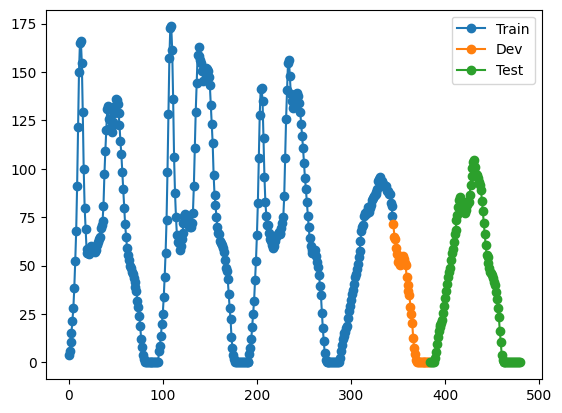

In [22]:
idx = random.randint(0, numbat_train_dataset[0].x.shape[0] -1)

train_val = [snapshot.y[idx] for snapshot in numbat_train_dataset]
dev_val = [snapshot.y[idx] for snapshot in numbat_dev_dataset]
test_val = [snapshot.y[idx] for snapshot in numbat_test_dataset]

num_snap_train = numbat_train_dataset.snapshot_count
num_snap_dev = numbat_dev_dataset.snapshot_count
num_snap_test = numbat_test_dataset.snapshot_count

plt.plot(range(num_snap_train),train_val, label='Train', marker='o')
plt.plot(range(num_snap_train, num_snap_train+ num_snap_dev),dev_val, label='Dev', marker='o')
plt.plot(range(num_snap_train+ num_snap_dev, num_snap_train+ num_snap_dev+num_snap_test),test_val, label='Test', marker='o')
plt.legend()
plt.show()

Epoch 0


  0%|          | 0/345 [00:00<?, ?it/s]c:\Users\tengo\Documents\Cours IAM - IAAA\IAM\Projet 3A\FlowForecasting\env\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([471])) that is different to the input size (torch.Size([471, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\tengo\Documents\Cours IAM - IAAA\IAM\Projet 3A\FlowForecasting\env\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1206])) that is different to the input size (torch.Size([1206, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 345/345 [00:04<00:00, 75.46it/s]


Train Loss - Entries 62972.875; Exits: 63965.66796875; Loads 328624.3125


100%|██████████| 39/39 [00:00<00:00, 100.72it/s]


Dev Loss - Entries 25408.18359375; Exits: 16875.662109375; Loads: 104728.0


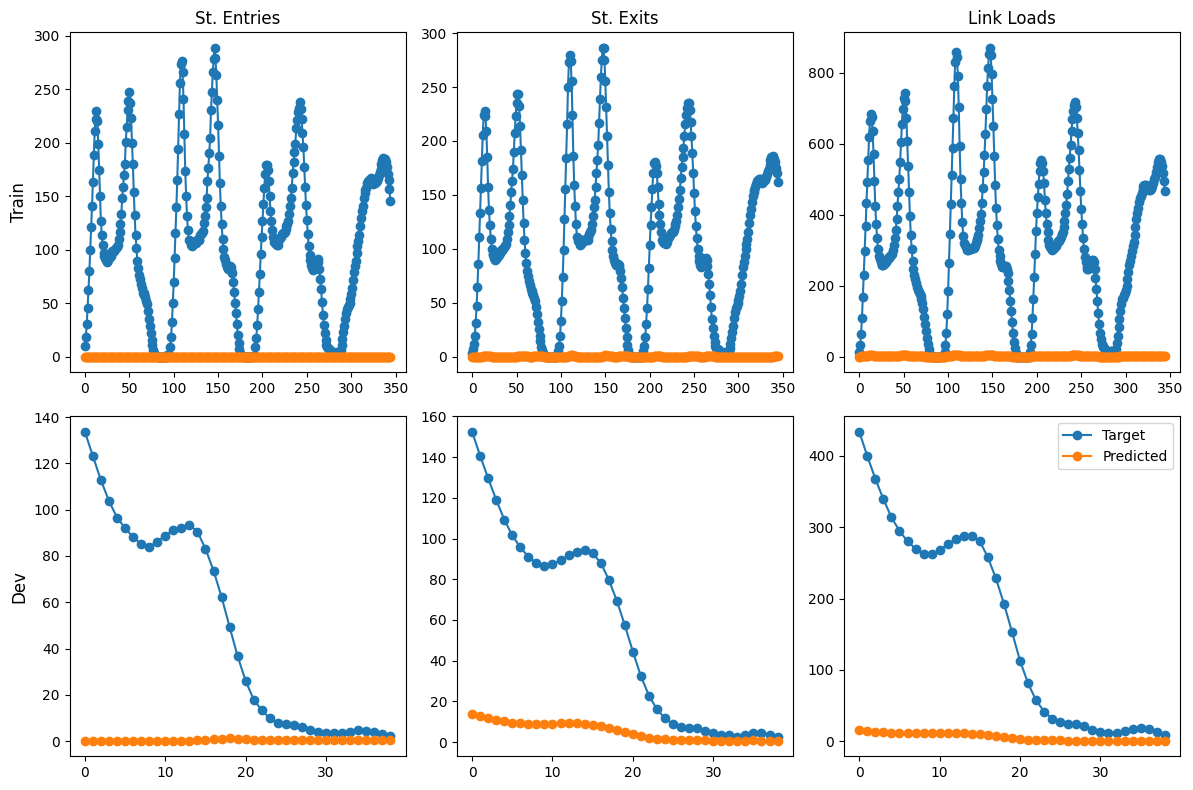

Epoch 1


100%|██████████| 345/345 [00:03<00:00, 92.56it/s] 


Epoch 2


100%|██████████| 345/345 [00:03<00:00, 94.51it/s] 


Epoch 3


100%|██████████| 345/345 [00:03<00:00, 95.23it/s] 


Epoch 4


100%|██████████| 345/345 [00:03<00:00, 97.50it/s] 


In [23]:
model = RecurrentGCN(num_lag_features=lag, num_date_features=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion =torch.nn.
criterion =torch.nn.MSELoss()
# criterion =torch.nn.L1Loss()
epochs = 5
num_stations = numbat_dev_dataset[0].x.shape[0]
num_links = numbat_dev_dataset[0].edge_index.shape[1]

for epoch in range(epochs):
    ### TRAIN

    model.train()
    print("Epoch", epoch)

    entries_train_loss = 0
    exits_train_loss = 0
    loads_train_loss = 0

    entries_pred_plot = np.empty((num_snap_train, num_stations))
    entries_true_plot = np.empty((num_snap_train, num_stations))

    exits_pred_plot = np.empty((num_snap_train, num_stations))
    exits_true_plot = np.empty((num_snap_train, num_stations))

    loads_pred_plot = np.empty((num_snap_train, num_links))
    loads_true_plot = np.empty((num_snap_train, num_links))

    for time, snapshot in tqdm(enumerate(numbat_train_dataset), total=num_snap_train):
        pred_entries, pred_exits, pred_loads = model(
            snapshot.x, 
            snapshot.features_exits, 
            snapshot.features_loads, 
            snapshot.edge_index, snapshot.edge_attr)
        entries_train_loss = entries_train_loss + criterion(pred_entries, snapshot.y)
        exits_train_loss = exits_train_loss + criterion(pred_exits, snapshot.targets_exits)
        loads_train_loss = loads_train_loss + criterion(pred_loads, snapshot.targets_loads)

        entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
        entries_true_plot[time] = snapshot.y.numpy()

        exits_pred_plot[time] = pred_exits.detach().squeeze().numpy()
        exits_true_plot[time] = snapshot.targets_exits.numpy()

        loads_pred_plot[time] = pred_loads.detach().squeeze().numpy()
        loads_true_plot[time] = snapshot.targets_loads.numpy()
    
    entries_train_loss = entries_train_loss / num_snap_train
    exits_train_loss = exits_train_loss / num_snap_train
    loads_train_loss = loads_train_loss / num_snap_train
    
    train_loss = entries_train_loss + exits_train_loss + loads_train_loss
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if epoch%10 == 0:
        # print("Train Loss:", train_loss.item())
        print("Train Loss - Entries {}; Exits: {}; Loads {}".format(
            entries_train_loss.item(), exits_train_loss.item(), loads_train_loss.item()
        ))
        
        fig, axs = plt.subplots(2, 3, sharex='row', figsize=(12, 8))

        for ax, col in zip(axs[0], ('St. Entries', 'St. Exits', 'Link Loads')):
            ax.set_title(col)

        for ax, row in zip(axs[:,0], ('Train', 'Dev')):
            ax.set_ylabel(row, size='large')
        axs[0,0].plot(range(num_snap_train),np.mean(entries_true_plot, axis=1), label='Target', marker='o')
        axs[0,0].plot(np.mean(entries_pred_plot, axis=1), label='Predicted', marker='o')

        axs[0,1].plot(np.mean(exits_true_plot, axis=1), label='Target', marker='o')
        axs[0,1].plot(np.mean(exits_pred_plot, axis=1), label='Predicted', marker='o')

        axs[0,2].plot(np.mean(loads_true_plot, axis=1), label='Target', marker='o')
        axs[0,2].plot(np.mean(loads_pred_plot, axis=1), label='Predicted', marker='o')

    ### EVAL
        model.eval()
        entries_dev_loss = 0
        exits_dev_loss = 0
        loads_dev_loss = 0

        entries_pred_plot = np.empty((num_snap_dev, num_stations))
        entries_true_plot = np.empty((num_snap_dev, num_stations))

        exits_pred_plot = np.empty((num_snap_dev, num_stations))
        exits_true_plot = np.empty((num_snap_dev, num_stations))

        loads_pred_plot = np.empty((num_snap_dev, num_links))
        loads_true_plot = np.empty((num_snap_dev, num_links))
        for time, snapshot in tqdm(enumerate(numbat_dev_dataset), total=num_snap_dev):
            pred_entries, pred_exits, pred_loads = model(
                snapshot.x, 
                snapshot.features_exits, 
                snapshot.features_loads, 
                snapshot.edge_index, snapshot.edge_attr)
            
            entries_dev_loss = entries_dev_loss + criterion(pred_entries, snapshot.y)
            exits_dev_loss = exits_dev_loss + criterion(pred_exits, snapshot.targets_exits)
            loads_dev_loss = loads_dev_loss + criterion(pred_loads, snapshot.targets_loads)

            entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
            entries_true_plot[time] = snapshot.y.numpy()

            exits_pred_plot[time] = pred_exits.detach().squeeze().numpy()
            exits_true_plot[time] = snapshot.targets_exits.numpy()

            loads_pred_plot[time] = pred_loads.detach().squeeze().numpy()
            loads_true_plot[time] = snapshot.targets_loads.numpy()

        entries_dev_loss = entries_dev_loss / num_snap_dev
        exits_dev_loss = exits_dev_loss / num_snap_dev
        loads_dev_loss = loads_dev_loss / num_snap_dev

        print("Dev Loss - Entries {}; Exits: {}; Loads: {}".format(
            entries_dev_loss.item(), exits_dev_loss.item(), loads_dev_loss.item()
        ))
        axs[1,0].plot(range(num_snap_dev),np.mean(entries_true_plot, axis=1), label='Target', marker='o')
        axs[1,0].plot(np.mean(entries_pred_plot, axis=1), label='Predicted', marker='o')

        axs[1,1].plot(np.mean(exits_true_plot, axis=1), label='Target', marker='o')
        axs[1,1].plot(np.mean(exits_pred_plot, axis=1), label='Predicted', marker='o')

        axs[1,2].plot(np.mean(loads_true_plot, axis=1), label='Target', marker='o')
        axs[1,2].plot(np.mean(loads_pred_plot, axis=1), label='Predicted', marker='o')

        fig.tight_layout()
        plt.legend()
        plt.show()

In [27]:
model.eval()
cost = 0
num_snapshot = numbat_test_dataset.snapshot_count
for time, snapshot in tqdm(enumerate(numbat_test_dataset), total=num_snapshot):
    y_hat, _, _ = model(snapshot.x, snapshot.features_exits, snapshot.features_loads, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / num_snapshot
cost = cost.item()
print("MSE Entries: {:.4f}".format(cost))

100%|██████████| 96/96 [00:00<00:00, 105.62it/s]

MSE Entries: 24544.2559


In [24]:
ts_predicted_loads = []
ts_predicted_entries = []
ts_predicted_exits = []

ts_true_loads = []
ts_true_entries = []
ts_true_exits = []

for _, snapshot in tqdm(enumerate(numbat_2023_ent_ex_dataset)):
    pred_entries, pred_exits, pred_loads = model(
        snapshot.x, 
        snapshot.features_exits, 
        snapshot.features_loads, 
        snapshot.edge_index, snapshot.edge_attr)
    
    for i in range(len(pred_entries)):
        ts_predicted_entries.append(pred_entries[i].detach().numpy()[0])
        ts_true_entries.append(float(snapshot.y[i].numpy()))

        ts_predicted_exits.append(pred_exits[i].detach().numpy()[0])
        ts_true_exits.append(float(snapshot.targets_exits[i].numpy()))

    for i, pred in enumerate(pred_loads):
        ts_predicted_loads.append(pred.detach().numpy()[0])
        ts_true_loads.append(float(snapshot.targets_loads[i].numpy()))


df_pred_link_loads = pd.DataFrame({'pred_flow' : ts_predicted_loads, 'actual_flow' : ts_true_loads})
df_pred_link_loads['From Station'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['From Station'])
df_pred_link_loads['To Station'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['To Station'])
df_pred_link_loads['Line'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['Line'])
df_pred_link_loads['Dir'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['Dir'])
df_pred_link_loads['Order'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['Order'])
df_pred_link_loads['Link'] = df_pred_link_loads.index.map(lambda x : link_data[x%num_links]['Link'])
df_pred_link_loads['time_idx'] = df_pred_link_loads.index.map(lambda x : x//num_links)

df_pred_station = pd.DataFrame({
    'pred_entries' : ts_predicted_entries,
    'actual_entries' : ts_true_entries,
    'pred_exits' : ts_predicted_exits,
    'actual_exits' : ts_true_exits
    })

df_pred_station['Station'] = df_pred_station.index.map(lambda x : station_data[x%num_stations]['Station'])
df_pred_station['NLC'] = df_pred_station.index.map(lambda x : station_data[x%num_stations]['NLC'])
df_pred_station['time_idx'] = df_pred_station.index.map(lambda x : x//num_stations)

480it [00:36, 13.30it/s]


### Dash visualization

In [42]:
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

#### Layout

##### Stations

In [43]:
df_plot = df_pred_station.groupby('time_idx')[['pred_entries', 'actual_entries', 'pred_exits', 'actual_exits']].mean().reset_index()
df_plot = df_plot.melt(
        id_vars=['time_idx'],
        value_vars=['pred_entries', 'actual_entries', 'pred_exits', 'actual_exits',],
        var_name='Type',
)

df_plot['Flow Type'] = df_plot['Type'].apply(lambda x: 'Entries' if 'entries' in x else 'Exits')
df_plot['Prediction Type'] = df_plot['Type'].apply(lambda x: 'Predicted' if 'pred' in x else 'Actual')

fig = px.line(
    df_plot,
    x='time_idx',
    y='value',
    facet_col="Flow Type",
    color='Prediction Type',
    title="Averaged Station Flows over Time"
)

station_tab = dbc.Tab(label="Stations", children=[
    dbc.Spinner(dcc.Graph(figure=fig)),
    html.P("Select a station:"),
    dcc.Dropdown(
        id='select-station',
        options=list(df_pred_station['Station'].unique()),
        searchable=True,
    ),
    dbc.Button(
        'Run',
        id='load-graph-station',
        class_name='btn-primary'

    ),
    dbc.Spinner(
        dcc.Graph(
            id="graph-station-flow",
        )
    ),
    
])

@app.callback(
    Output("graph-station-flow", "figure"), 
    Input('load-graph-station', 'n_clicks'),
    State("select-station", "value"),
    prevent_initial_call=True
    )

def display_station_graph(n_clicks, station):
    df_plot = df_pred_station[(df_pred_station['Station'] == station)].reset_index(drop=True)
    df_plot = df_plot.melt(
        id_vars=['time_idx', 'Station', 'NLC'],
        value_vars=['pred_entries', 'actual_entries', 'pred_exits', 'actual_exits'],
        var_name='Type',
    ).sort_values(by=['time_idx'])
    
    df_plot['Flow Type'] = df_plot['Type'].apply(lambda x: 'Entries' if 'entries' in x else 'Exits')
    df_plot['Prediction Type'] = df_plot['Type'].apply(lambda x: 'Predicted' if 'pred' in x else 'Actual')

    fig = px.line(
        df_plot,
        x='time_idx',
        y='value',
        facet_col="Flow Type",
        color='Prediction Type',
        title=f"Station Flows over Time for {station}"
    )
    
    
    return fig

##### Links

In [44]:
df_plot = df_pred_link_loads.groupby('time_idx')[['actual_flow', 'pred_flow']].mean().reset_index()
df_plot = df_plot.melt(
        id_vars=['time_idx'],
        value_vars=['actual_flow', 'pred_flow'],
        var_name='Type',
)

fig = px.line(
    df_plot,
    x='time_idx',
    y='value',
    color='Type',
    title="Averaged Link Load over Time"
)

links_tab = dbc.Tab(label="Links", children=[
    dbc.Spinner(dcc.Graph(figure=fig)),
    html.P("Select a link:"),
    dcc.Dropdown(
        id='select-link',
        options=[{'label' : f"{link_data[i]['From Station']} - {link_data[i]['To Station']}", 'value' : link_data[i]['Link']} for i in range(num_links)],
        searchable=True,
    ),
    dbc.Button(
        'Run',
        id='load-graph-link',
        class_name='btn-primary'

    ),
    dbc.Spinner(
        dcc.Graph(
            id="graph-link-flow",
        )
    ),
    
])

@app.callback(
    Output("graph-link-flow", "figure"), 
    Input('load-graph-link', 'n_clicks'),
    State("select-link", "value"),
    prevent_initial_call=True
    )

def display_link_graph(n_clicks, link):
    df_plot = df_pred_link_loads[(df_pred_link_loads['Link'] == link)].reset_index(drop=True)
    df_plot = df_plot.melt(
        id_vars=['Order', 'Link', 'From Station', 'To Station', 'time_idx'],
        value_vars=['actual_flow', 'pred_flow'],
        var_name='Type',

    ).sort_values(by=['time_idx'])
    
    fig = px.line(
        df_plot,
        x='time_idx',
        y='value',
        color='Type',
        title=f"Station Flow for {link}"
    )
    
    
    return fig

##### Lines

In [45]:
lines_tab = dbc.Tab(label="Lines", children=[
    html.P("Select a line:"),
    dcc.Dropdown(
        id='select-line',
        options=list(df_pred_link_loads['Line'].unique()),
    ),
    html.P("Select a direction:"),
    dbc.RadioItems(
        id='select-dir',
        options=[],
        inline=True,
    ),
    dbc.Button(
        'Run',
        id='load-graph',
        class_name='btn-primary'

    ),
    dbc.Spinner(
        dcc.Graph(
            id="graph-line-flow",
        )
    ),
])

@app.callback(
    Output("select-dir", "options"),
    Input("select-line", "value"),
    prevent_initial_call=True,
)
def update_line_directions(line):
    return lines_directions[line]

@app.callback(
    Output("graph-line-flow", "figure"), 
    Input('load-graph', 'n_clicks'),
    State("select-line", "value"),
    State("select-dir", "value"),
    prevent_initial_call=True
    )
def display_lines_graph(n_clicks, line, dir):
    df_plot = df_pred_link_loads[(df_pred_link_loads['Line'] == line) & (df_pred_link_loads['Dir'] == dir)].reset_index(drop=True)

    df_plot = df_plot.melt(
        id_vars=['Order', 'Link', 'From Station', 'To Station', 'time_idx'],
        value_vars=['actual_flow', 'pred_flow'],
        var_name='Type',

    ).sort_values(by=['Order', 'time_idx'])
    fig = px.line(df_plot, 
        x='Order',
        y='value',
        color='Type',
        # y='pred_flow',
        # error_y='flow',
        # y='flow',
        animation_frame='time_idx',
        hover_name='Link',
        hover_data=['From Station', 'To Station'],
        range_y=[min(df_plot['value'].min(),df_plot['value'].min()), max(df_plot['value'].max(),df_plot['value'].max())]
        )
    
    
    return fig

#### Run App

In [46]:
app.layout = dbc.Container([
    html.H1('Flow Forecasting'),
    dbc.Tabs([
        station_tab,
        links_tab,
        lines_tab,
    ]),
])

app.run_server(debug=True, jupyter_mode="tab")

Dash app running on http://127.0.0.1:8050/


<IPython.core.display.Javascript object>

### Sliding Split

In [59]:
numbat_2023_ent_ex_dataset = StaticGraphTemporalSignal(
    edge_index=edge_idx,
    edge_weight=None,
    features=station_entries_features,
    targets=station_entries,
    features_exits=station_exits_features,
    targets_exits=station_exits,
    features_loads=link_loads_features,
    targets_loads=link_loads,
)

n_splits=8
tscv = TimeSeriesSplit(
    n_splits=n_splits,
    max_train_size=192,
    gap=48 #12 hours gap
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

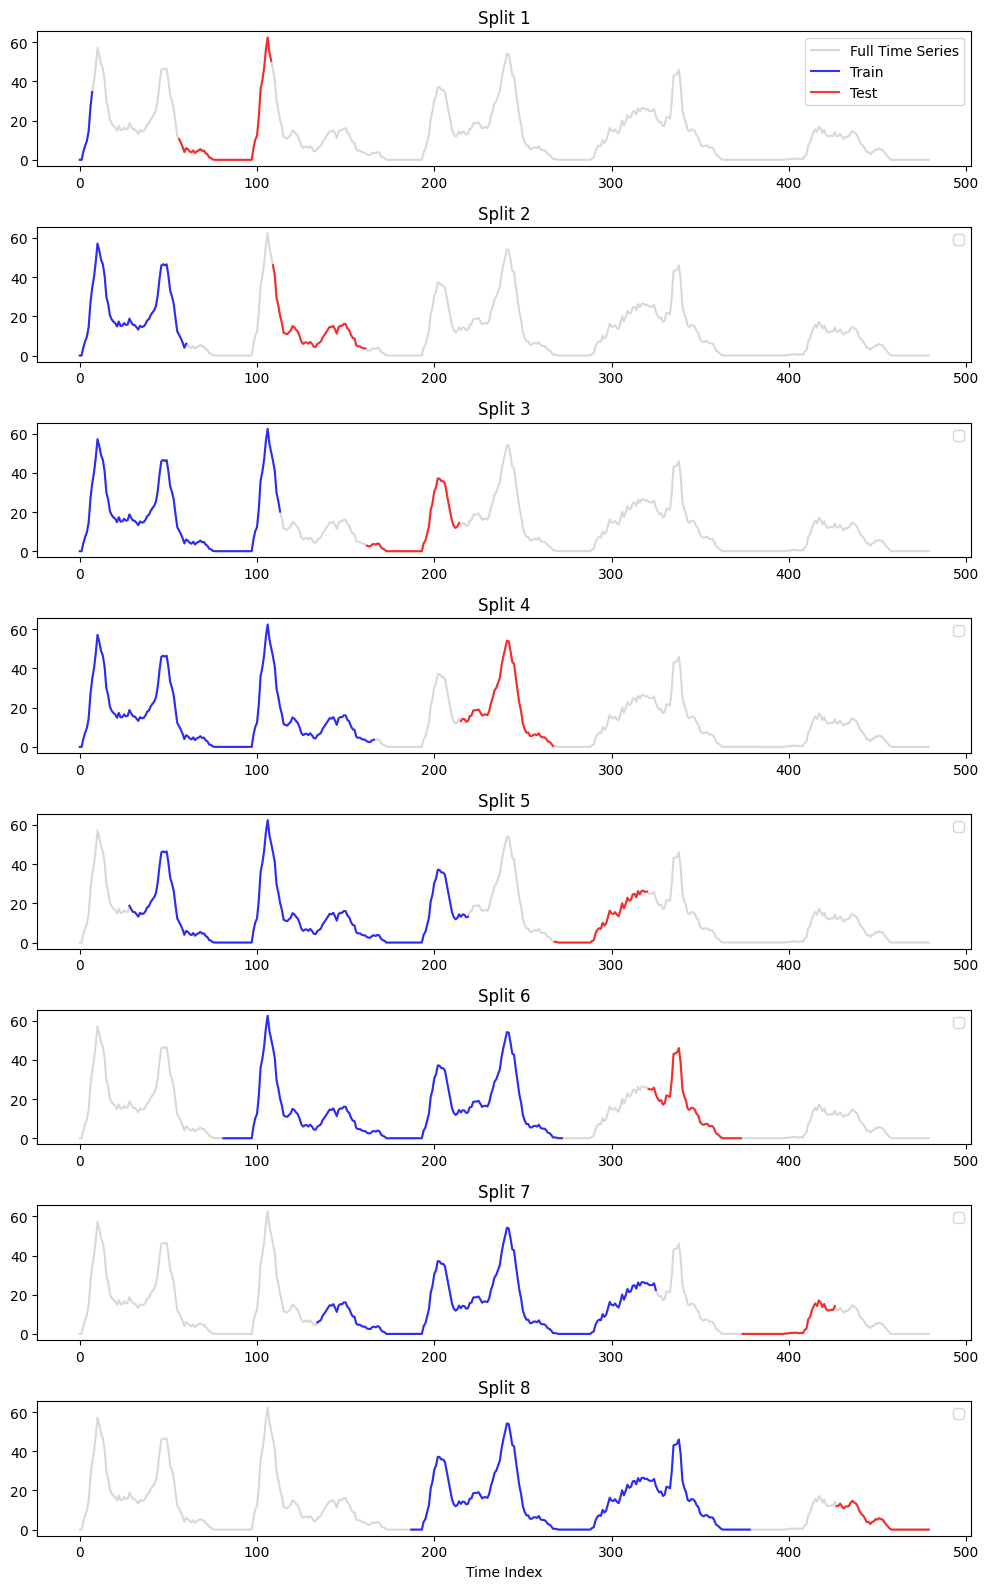

In [60]:
idx = random.randint(0, numbat_2023_ent_ex_dataset[0].x.shape[0] -1)

fig, axes = plt.subplots(n_splits, 1, figsize=(10, 2 * n_splits))
target_val = np.array([snapshot.y[idx] for snapshot in numbat_2023_ent_ex_dataset])

# Loop over the splits and plot train/test sets separately
for i, (train_index, test_index) in enumerate(tscv.split(list(numbat_2023_ent_ex_dataset))):
    ax = axes[i]
    # Plot the full series with low opacity for context
    ax.plot(range(len(target_val)), target_val, color='gray', alpha=0.3, label='Full Time Series' if i == 0 else "")
    
    # Highlight train and test sets
    ax.plot(train_index, target_val[train_index], color='blue', alpha=0.8, label='Train' if i == 0 else "")
    ax.plot(test_index, target_val[test_index], color='red', alpha=0.8, label='Test' if i == 0 else "")
    
    ax.set_title(f"Split {i+1}")
    ax.legend()

# Adjust layout
plt.xlabel("Time Index")
plt.tight_layout()
plt.show()

In [61]:
# criterion =torch.nn.L1Loss()
epochs = 10
epoch_plot = epochs // 10

num_stations = numbat_2023_ent_ex_dataset[0].x.shape[0]
num_links = numbat_2023_ent_ex_dataset[0].edge_index.shape[1]

# all_splits = list(tscv.split(list(numbat_2023_ent_ex_dataset)))
for idx_split, (train_idx, dev_idx) in enumerate(tscv.split(list(numbat_2023_ent_ex_dataset))):
# train_idx, dev_idx = all_splits[idx_split]

    model = RecurrentGCN(num_lag_features=lag, num_date_features=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion =torch.nn.MSELoss()
    
    num_snap_train = len(train_idx)
    num_snap_dev = len(dev_idx)

    for epoch in range(epochs):
        ### TRAIN

        model.train()
        print("Epoch", epoch)

        entries_train_loss = 0
        exits_train_loss = 0
        loads_train_loss = 0

        entries_pred_plot = np.empty((num_snap_train, num_stations))
        entries_true_plot = np.empty((num_snap_train, num_stations))

        exits_pred_plot = np.empty((num_snap_train, num_stations))
        exits_true_plot = np.empty((num_snap_train, num_stations))

        loads_pred_plot = np.empty((num_snap_train, num_links))
        loads_true_plot = np.empty((num_snap_train, num_links))

        for time in tqdm(range(num_snap_train), total=num_snap_train):
            snapshot = numbat_2023_ent_ex_dataset[time]
            pred_entries, pred_exits, pred_loads = model(
                snapshot.x, 
                snapshot.features_exits, 
                snapshot.features_loads, 
                snapshot.edge_index, snapshot.edge_attr)
            entries_train_loss = entries_train_loss + criterion(pred_entries, snapshot.y)
            exits_train_loss = exits_train_loss + criterion(pred_exits, snapshot.targets_exits)
            loads_train_loss = loads_train_loss + criterion(pred_loads, snapshot.targets_loads)

            entries_pred_plot[time] = pred_entries.detach().squeeze().numpy()
            entries_true_plot[time] = snapshot.y.numpy()

            exits_pred_plot[time] = pred_exits.detach().squeeze().numpy()
            exits_true_plot[time] = snapshot.targets_exits.numpy()

            loads_pred_plot[time] = pred_loads.detach().squeeze().numpy()
            loads_true_plot[time] = snapshot.targets_loads.numpy()
        
        entries_train_loss = entries_train_loss / num_snap_train
        exits_train_loss = exits_train_loss / num_snap_train
        loads_train_loss = loads_train_loss / num_snap_train
        
        train_loss = entries_train_loss + exits_train_loss + loads_train_loss
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print("Train Loss - Entries {}; Exits: {}; Loads {}".format(
            entries_train_loss.item(), exits_train_loss.item(), loads_train_loss.item()
        ))

        model.eval()
        entries_dev_loss = 0
        exits_dev_loss = 0
        loads_dev_loss = 0

        for time in tqdm(range(num_snap_dev), total=num_snap_dev):
            snapshot = numbat_2023_ent_ex_dataset[time]
            pred_entries, pred_exits, pred_loads = model(
                snapshot.x, 
                snapshot.features_exits, 
                snapshot.features_loads, 
                snapshot.edge_index, snapshot.edge_attr)
            
            entries_dev_loss = entries_dev_loss + criterion(pred_entries, snapshot.y)
            exits_dev_loss = exits_dev_loss + criterion(pred_exits, snapshot.targets_exits)
            loads_dev_loss = loads_dev_loss + criterion(pred_loads, snapshot.targets_loads)

        entries_dev_loss = entries_dev_loss / num_snap_dev
        exits_dev_loss = exits_dev_loss / num_snap_dev
        loads_dev_loss = loads_dev_loss / num_snap_dev

        print("Dev Loss - Entries {}; Exits: {}; Loads: {}".format(
            entries_dev_loss.item(), exits_dev_loss.item(), loads_dev_loss.item()
        ))

Epoch 0


  0%|          | 0/8 [00:00<?, ?it/s]c:\Users\tengo\Documents\Cours IAM - IAAA\IAM\Projet 3A\FlowForecasting\env\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning:

Using a target size (torch.Size([471])) that is different to the input size (torch.Size([471, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

c:\Users\tengo\Documents\Cours IAM - IAAA\IAM\Projet 3A\FlowForecasting\env\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning:

Using a target size (torch.Size([1206])) that is different to the input size (torch.Size([1206, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100%|██████████| 8/8 [00:00<00:00, 13.85it/s]


Train Loss - Entries 12636.6298828125; Exits: 10247.69921875; Loads 101371.640625


100%|██████████| 53/53 [00:02<00:00, 20.03it/s]


Dev Loss - Entries 74599.78125; Exits: 73406.1015625; Loads: 390670.0
Epoch 1


100%|██████████| 8/8 [00:00<00:00, 61.40it/s]


Train Loss - Entries 12636.6298828125; Exits: 10054.380859375; Loads 97845.7890625


100%|██████████| 53/53 [00:01<00:00, 41.08it/s]


Dev Loss - Entries 74599.78125; Exits: 72918.78125; Loads: 373037.96875
Epoch 2


100%|██████████| 8/8 [00:00<00:00, 36.74it/s]


Train Loss - Entries 12636.6298828125; Exits: 10131.72265625; Loads 93118.4453125


100%|██████████| 53/53 [00:01<00:00, 48.42it/s]


Dev Loss - Entries 74599.78125; Exits: 72945.328125; Loads: 348288.375
Epoch 3


100%|██████████| 8/8 [00:00<00:00, 39.20it/s]


Train Loss - Entries 12636.6298828125; Exits: 10119.24609375; Loads 87605.0859375


100%|██████████| 53/53 [00:01<00:00, 44.02it/s]


Dev Loss - Entries 74599.78125; Exits: 73172.2890625; Loads: 324474.90625
Epoch 4


100%|██████████| 8/8 [00:00<00:00, 44.82it/s]


Train Loss - Entries 12636.6298828125; Exits: 10055.4072265625; Loads 85512.09375


100%|██████████| 53/53 [00:01<00:00, 38.26it/s]


Dev Loss - Entries 74599.78125; Exits: 73639.5078125; Loads: 319281.84375
Epoch 5


100%|██████████| 8/8 [00:00<00:00, 46.38it/s]


Train Loss - Entries 12636.6298828125; Exits: 10013.712890625; Loads 90059.7890625


100%|██████████| 53/53 [00:01<00:00, 30.59it/s]


Dev Loss - Entries 74599.78125; Exits: 74294.53125; Loads: 319409.25
Epoch 6


100%|██████████| 8/8 [00:00<00:00, 41.61it/s]


Train Loss - Entries 12636.6298828125; Exits: 10005.6240234375; Loads 87894.890625


100%|██████████| 53/53 [00:01<00:00, 41.65it/s]


Dev Loss - Entries 74599.78125; Exits: 74778.8203125; Loads: 323799.84375
Epoch 7


100%|██████████| 8/8 [00:00<00:00, 46.70it/s]


Train Loss - Entries 12636.6298828125; Exits: 10011.548828125; Loads 85470.046875


100%|██████████| 53/53 [00:01<00:00, 41.35it/s]


Dev Loss - Entries 74599.78125; Exits: 74688.515625; Loads: 331739.40625
Epoch 8


100%|██████████| 8/8 [00:00<00:00, 27.30it/s]


Train Loss - Entries 12636.6298828125; Exits: 9996.5009765625; Loads 85189.90625


100%|██████████| 53/53 [00:01<00:00, 38.83it/s]


Dev Loss - Entries 74599.78125; Exits: 74296.421875; Loads: 338804.34375
Epoch 9


100%|██████████| 8/8 [00:00<00:00, 60.99it/s]


Train Loss - Entries 12636.6298828125; Exits: 9974.7451171875; Loads 85873.109375


100%|██████████| 53/53 [00:01<00:00, 39.29it/s]


Dev Loss - Entries 74599.78125; Exits: 73887.015625; Loads: 342796.65625
Epoch 0


100%|██████████| 61/61 [00:01<00:00, 37.87it/s]


Train Loss - Entries 73838.4375; Exits: 77715.078125; Loads 416807.375


100%|██████████| 53/53 [00:01<00:00, 37.07it/s]


Dev Loss - Entries 69314.984375; Exits: 78127.65625; Loads: 404799.3125
Epoch 1


100%|██████████| 61/61 [00:01<00:00, 33.77it/s]


Train Loss - Entries 71929.609375; Exits: 77712.578125; Loads 416807.375


100%|██████████| 53/53 [00:01<00:00, 36.07it/s]


Dev Loss - Entries 68544.15625; Exits: 78121.734375; Loads: 404799.3125
Epoch 2


100%|██████████| 61/61 [00:01<00:00, 52.77it/s]


Train Loss - Entries 71228.15625; Exits: 77706.8125; Loads 416807.375


100%|██████████| 53/53 [00:01<00:00, 52.83it/s]


Dev Loss - Entries 69020.4296875; Exits: 76922.9140625; Loads: 404799.3125
Epoch 3


100%|██████████| 61/61 [00:01<00:00, 46.59it/s]


Train Loss - Entries 71760.4296875; Exits: 76512.5390625; Loads 416807.375


100%|██████████| 53/53 [00:01<00:00, 41.52it/s]


Dev Loss - Entries 69142.6015625; Exits: 75414.9609375; Loads: 404799.3125
Epoch 4


100%|██████████| 61/61 [00:01<00:00, 47.39it/s]


Train Loss - Entries 71885.1328125; Exits: 74939.953125; Loads 416807.375


100%|██████████| 53/53 [00:01<00:00, 40.74it/s]


Dev Loss - Entries 68833.8984375; Exits: 74000.5703125; Loads: 404799.3125
Epoch 5


100%|██████████| 61/61 [00:01<00:00, 43.61it/s]


Train Loss - Entries 71555.140625; Exits: 73435.671875; Loads 416807.375


100%|██████████| 53/53 [00:01<00:00, 35.22it/s]


Dev Loss - Entries 68514.1484375; Exits: 73052.7421875; Loads: 404799.3125
Epoch 6


100%|██████████| 61/61 [00:01<00:00, 34.76it/s]


Train Loss - Entries 71211.046875; Exits: 72349.078125; Loads 416807.375


  6%|▌         | 3/53 [00:00<00:03, 14.44it/s]


KeyboardInterrupt: 

In [ ]:
model.eval()
cost = 0
num_snapshot = numbat_test_dataset.snapshot_count
for time, snapshot in tqdm(enumerate(numbat_test_dataset), total=num_snapshot):
    y_hat, _, _ = model(snapshot.x, snapshot.features_exits, snapshot.features_loads, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / num_snapshot
cost = cost.item()
print("MSE Entries: {:.4f}".format(cost))

100%|██████████| 96/96 [00:00<00:00, 107.17it/s]

MSE Entries: 22153.2754
